# Block vs non-block, normalisation vs non-normalisation - One Dimensional analysis, using user RL code and random data

Modified with precision parameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Choose a single line as data

In [2]:
dwidth = 2048

In [3]:
data = np.random.randint(0,255,size=dwidth)

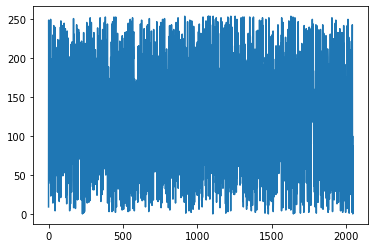

In [4]:
plt.plot(data)

In [5]:
1024+512

1536

## Generate a random psf data source

In [6]:
psf_source = np.random.rand(512).astype(np.float32)

In [7]:
psf_source.dtype

dtype('float32')

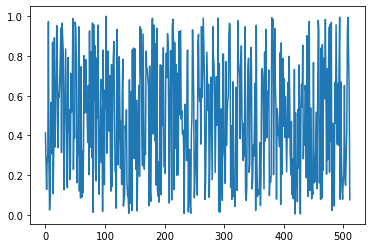

In [8]:
plt.plot(psf_source)

## RL deconvolution, user code

In [9]:
def RL0(data, psf, niter, do_edge_norm=True):
    #Richardson-Lucy deconvolution
    # with optional edge normalisation

    #print("data.shape :",data.shape)
    #print("psf shape :", psf.shape)
    #Uses normalisation of data for extended size

    #Check data is one dim
    if data.ndim!= 1 and psf.ndim!=1:
        print ("Error: data and/or psf are not 1D. Returning None")
        return None
    
    # #Make sure data shape is even by cropping extra if needed
    # if data.shape[0] % 2 != 0 :
    #     data = data[:-1]
    #     print("new data.shape :",data.shape)

    #make sure psf is normalised sum
    psf0 = psf/ psf.sum()

    #Create a psf-like array that will be used to resize data
    delta_arr = np.zeros_like(psf0)
    phw = int(psf0.shape[0]/2) #Half-width of the psf
    delta_arr[ phw ] = 1.0 #delta-dirac style array, mid point with value 1.0
    data_shaped = np.convolve(data, delta_arr, mode='full')
    #print("data_shaped shape:", data_shaped.shape)

    #Create a normalisation array
    # a technique that helps slowing the reduction of edge effects with growing niter
    onesarray = np.ones_like(data)
    normarray = np.convolve(onesarray, psf0,mode='full')

    psf0_flip = np.flip(psf0)

    xn1 = np.array(data) #Initialise copy

    for i in range(niter):
        #print("iteration: ", i)
        xn=xn1
        #Convolution at denominator
        u0 = np.convolve(xn, psf0, mode='full')
        #print("u0 shape:", u0.shape)

        #Division
        div0 = data_shaped / u0 #TODO: check sizes are compatible

        #Convolve the result with flipped psf
        u2 = np.convolve(div0,psf0_flip, mode='same') #Use same setting to crop result
        #print("u2 shape:", u2.shape)

        #Multiplication with previous estimation
        #mult0 = np.multiply(xn, u2) #Error in sizes, should use extended previous estimation
        xn_ext = np.convolve(xn, delta_arr, mode='full') #use 'trick' to resize data
        #print("xn_ext shape:", xn_ext.shape)

        mult0 = np.multiply(xn_ext,u2)

        norm0 = None
        #Optionally divide with normalisation array
        if do_edge_norm==True:
            norm0 = np.divide(mult0, normarray)
        else:
            norm0= mult0

        #crop result to original size
        xn1 = norm0[phw:-phw+1]
        #print("xn1 shape:", xn1.shape)

    res = xn1

    return res

## max_valid_width vs niter and psf size

In [10]:
from scipy import signal
from numpy.random import default_rng
def crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0=512, x_crop_1=1536, niter0=20, psf_half_width0=8 , psf_x_start=200, sq_precision=1e-12, *, do_edge_norm=False):

    #Get maximum width
    def _get_max_width(data1, data2, sq_precision = 1e-12):
        diffsq0 = np.power( data1 - data2, 2)
        diffsq_valid0 = diffsq0 < sq_precision

        maxwidth0=0
        width0=0
        for i in range(diffsq_valid0.shape[0]):
            v0 = diffsq_valid0[i]
            if v0==1:
                width0+=1
            else:
                width0==0
            maxwidth0 = max(maxwidth0,width0)
        return maxwidth0

    #create gaussian psf with given width
    psf_width0 = 2*psf_half_width0

    #Uses the data itself to get the psf
    psfdata_crop = psf_source[psf_x_start: psf_x_start+psf_width0]
    psf_norm0 = psfdata_crop / psfdata_crop.sum()

    #x_crop_0, x_crop_1 = 100 , 350
    data_crop0 = data[x_crop_0:x_crop_1]

    #RL deconvolution on the original data and in the cropped data
    deconv_skimageRL0 = RL0(data,psf_norm0, niter0, do_edge_norm) # no edge normalisation
    deconv_skimageRL_crop0 = RL0(data_crop0,psf_norm0, niter0, do_edge_norm)

    #Get difference and max_width
    #diffsq0 = np.power( deconv_skimageRL_crop0 - deconv_skimageRL0[x_crop_0:x_crop_1 ], 2)
    #diffsq_valid0 = diffsq0 < 1e-12
    #m0 = _get_max_width(diffsq_valid0)

    m0 = _get_max_width(deconv_skimageRL_crop0, deconv_skimageRL0[x_crop_0:x_crop_1 ] , sq_precision)
    return m0

In [11]:
#test,1 iteration
crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400, 1000 , 1)

570

## Get maxwidth as a function of number of iterations and precision for fixed psf size

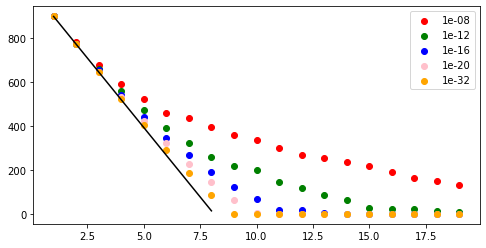

In [12]:
niter_range = np.arange(1,20)
sq_precisions = [1e-8, 1e-12, 1e-16, 1e-20, 1e-32]
colors=['r','g','b','pink', 'orange']

psf_width=32

x_crop_0 = 512
datacrop_width = 1024

fig,ax = plt.subplots(1,1,figsize=(8,4))

for sqprec0, color in zip(sq_precisions, colors):
    maxwidths_vs_niter_and_sqprec = []

    for niter0 in niter_range:

        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0,x_crop_0+datacrop_width, niter0, psf_width, psf_x_start=200, sq_precision=sqprec0)
        #print("niter0: ", niter0 , ", sq_prec:", sqprec0 , ", maxwidth:", maxwidth)
        maxwidths_vs_niter_and_sqprec.append( (niter0,maxwidth) )
    
    ax.scatter(*zip(*maxwidths_vs_niter_and_sqprec), c=color, label=str(sqprec0))

#Calculate theoretical maxwidth
maxwidths_vs_niter_theor = []
for niter0 in niter_range:
    maxwidth0 = datacrop_width + niter0*(2-4*psf_width)
    if maxwidth0>0:
        maxwidths_vs_niter_theor.append( (niter0, maxwidth0 ))

ax.plot(*zip(*maxwidths_vs_niter_theor), c='black')

plt.legend()
plt.show()

The variation of max valid width with the precision for higher number of iterations clearly depends on the precision set. The higher the precision the closer it gets to the theoretical curve.

## Get maxwidth as a function of number of iterations and psf size

In [13]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth = []
for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 512,1536, niter0, phw0)
        print("niter0: ", niter0 , ", psf_width:", phw0 , ", maxwidth:", maxwidth)
        maxwidths_vs_niter_and_psfhwidth.append( (niter0,phw0,maxwidth) )

niter0:  1 , psf_width: 8 , maxwidth: 994
niter0:  1 , psf_width: 9 , maxwidth: 990
niter0:  1 , psf_width: 10 , maxwidth: 986
niter0:  1 , psf_width: 11 , maxwidth: 982
niter0:  1 , psf_width: 12 , maxwidth: 978
niter0:  1 , psf_width: 13 , maxwidth: 974
niter0:  1 , psf_width: 14 , maxwidth: 970
niter0:  1 , psf_width: 15 , maxwidth: 966
niter0:  1 , psf_width: 16 , maxwidth: 962
niter0:  1 , psf_width: 17 , maxwidth: 958
niter0:  1 , psf_width: 18 , maxwidth: 954
niter0:  1 , psf_width: 19 , maxwidth: 950
niter0:  1 , psf_width: 20 , maxwidth: 946
niter0:  1 , psf_width: 21 , maxwidth: 942
niter0:  1 , psf_width: 22 , maxwidth: 938
niter0:  1 , psf_width: 23 , maxwidth: 934
niter0:  1 , psf_width: 24 , maxwidth: 930
niter0:  1 , psf_width: 25 , maxwidth: 926
niter0:  1 , psf_width: 26 , maxwidth: 922
niter0:  1 , psf_width: 27 , maxwidth: 918
niter0:  1 , psf_width: 28 , maxwidth: 914
niter0:  1 , psf_width: 29 , maxwidth: 910
niter0:  1 , psf_width: 30 , maxwidth: 907
niter0:  1 , 

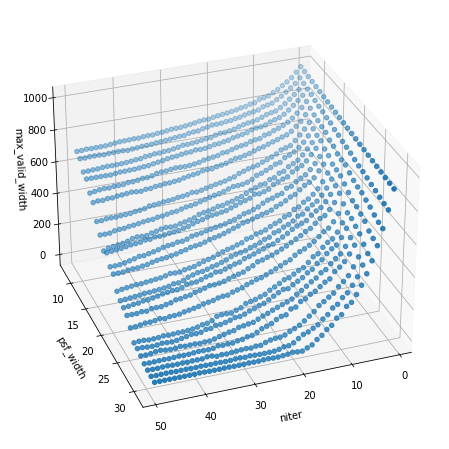

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth))
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=70)
plt.show()

## Compare with theoretical formula of 'valid' region after convolution

The invalid region increases by $2p-2$ per iteration. The factor of 2 appears because of a double convolution in the R_L iterative formula

Then, each RL (2 convolutions) leads to a valid size that is smaller than original data given by formula

$ M_n = m + n(2-2p)$

with m being the original data length.

In [15]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth_RL= []
maxwidths_vs_niter_and_psfhwidth_theory = []

x_crop_0 = 512
datacrop_width = 1024

print(f"datacrop_width: {datacrop_width}")

for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0, x_crop_0+datacrop_width, niter0, phw0)
        maxwidths_vs_niter_and_psfhwidth_RL.append( (niter0,phw0,maxwidth) )

        maxwidth_theory = datacrop_width + niter0*(2-4*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_and_psfhwidth_theory.append((niter0,phw0, maxwidth_theory))

        print("niter0: ", niter0 , ", psf_half_width:", phw0 , ", maxwidth:", maxwidth, " maxwidth_theory:", maxwidth_theory)


datacrop_width: 1024
niter0:  1 , psf_half_width: 8 , maxwidth: 994  maxwidth_theory: 994
niter0:  1 , psf_half_width: 9 , maxwidth: 990  maxwidth_theory: 990
niter0:  1 , psf_half_width: 10 , maxwidth: 986  maxwidth_theory: 986
niter0:  1 , psf_half_width: 11 , maxwidth: 982  maxwidth_theory: 982
niter0:  1 , psf_half_width: 12 , maxwidth: 978  maxwidth_theory: 978
niter0:  1 , psf_half_width: 13 , maxwidth: 974  maxwidth_theory: 974
niter0:  1 , psf_half_width: 14 , maxwidth: 970  maxwidth_theory: 970
niter0:  1 , psf_half_width: 15 , maxwidth: 966  maxwidth_theory: 966
niter0:  1 , psf_half_width: 16 , maxwidth: 962  maxwidth_theory: 962
niter0:  1 , psf_half_width: 17 , maxwidth: 958  maxwidth_theory: 958
niter0:  1 , psf_half_width: 18 , maxwidth: 954  maxwidth_theory: 954
niter0:  1 , psf_half_width: 19 , maxwidth: 950  maxwidth_theory: 950
niter0:  1 , psf_half_width: 20 , maxwidth: 946  maxwidth_theory: 946
niter0:  1 , psf_half_width: 21 , maxwidth: 942  maxwidth_theory: 942
n

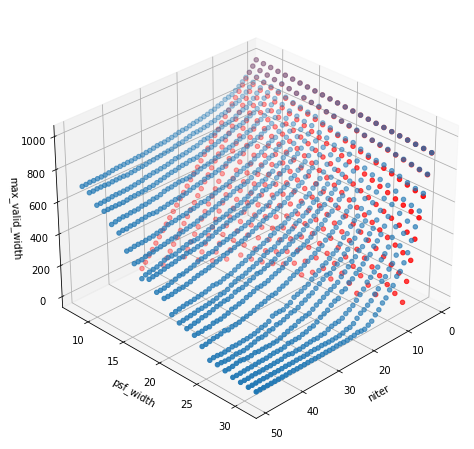

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_RL))
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_theory), c='red')
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=45)
plt.show()

In [17]:
maxwidths_vs_niter_and_psfhwidth_RL
# ( niter, psfwidth, maxwidth)

[(1, 8, 994),
 (1, 9, 990),
 (1, 10, 986),
 (1, 11, 982),
 (1, 12, 978),
 (1, 13, 974),
 (1, 14, 970),
 (1, 15, 966),
 (1, 16, 962),
 (1, 17, 958),
 (1, 18, 954),
 (1, 19, 950),
 (1, 20, 946),
 (1, 21, 942),
 (1, 22, 938),
 (1, 23, 934),
 (1, 24, 930),
 (1, 25, 926),
 (1, 26, 922),
 (1, 27, 918),
 (1, 28, 914),
 (1, 29, 910),
 (1, 30, 907),
 (1, 31, 903),
 (2, 8, 964),
 (2, 9, 956),
 (2, 10, 948),
 (2, 11, 940),
 (2, 12, 934),
 (2, 13, 924),
 (2, 14, 916),
 (2, 15, 910),
 (2, 16, 901),
 (2, 17, 897),
 (2, 18, 885),
 (2, 19, 879),
 (2, 20, 869),
 (2, 21, 863),
 (2, 22, 856),
 (2, 23, 846),
 (2, 24, 837),
 (2, 25, 832),
 (2, 26, 824),
 (2, 27, 814),
 (2, 28, 807),
 (2, 29, 798),
 (2, 30, 790),
 (2, 31, 783),
 (3, 8, 935),
 (3, 9, 925),
 (3, 10, 914),
 (3, 11, 906),
 (3, 12, 895),
 (3, 13, 881),
 (3, 14, 867),
 (3, 15, 860),
 (3, 16, 850),
 (3, 17, 844),
 (3, 18, 825),
 (3, 19, 816),
 (3, 20, 798),
 (3, 21, 791),
 (3, 22, 789),
 (3, 23, 770),
 (3, 24, 754),
 (3, 25, 744),
 (3, 26, 739),
 

In [18]:
maxwidths_vs_niter_and_psfhwidth_RL_np = np.array(maxwidths_vs_niter_and_psfhwidth_RL)
filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == 8

In [19]:
filter

array([ True, False, False, ..., False, False, False])

In [20]:

maxwidths_vs_niter_and_psfhwidth_RL_np_filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]

In [21]:
maxwidths_vs_niter_and_psfhwidth_RL_np_filtered

array([[  1,   8, 994],
       [  2,   8, 964],
       [  3,   8, 935],
       [  4,   8, 913],
       [  5,   8, 894],
       [  6,   8, 875],
       [  7,   8, 859],
       [  8,   8, 844],
       [  9,   8, 837],
       [ 10,   8, 832],
       [ 11,   8, 816],
       [ 12,   8, 811],
       [ 13,   8, 801],
       [ 14,   8, 797],
       [ 15,   8, 789],
       [ 16,   8, 784],
       [ 17,   8, 779],
       [ 18,   8, 775],
       [ 19,   8, 772],
       [ 20,   8, 767],
       [ 21,   8, 760],
       [ 22,   8, 760],
       [ 23,   8, 757],
       [ 24,   8, 751],
       [ 25,   8, 746],
       [ 26,   8, 742],
       [ 27,   8, 738],
       [ 28,   8, 737],
       [ 29,   8, 736],
       [ 30,   8, 731],
       [ 31,   8, 727],
       [ 32,   8, 725],
       [ 33,   8, 720],
       [ 34,   8, 721],
       [ 35,   8, 719],
       [ 36,   8, 715],
       [ 37,   8, 716],
       [ 38,   8, 714],
       [ 39,   8, 713],
       [ 40,   8, 712],
       [ 41,   8, 709],
       [ 42,   8

In [22]:
maxwidths_vs_niter_and_psfhwidth_RL_np = np.array(maxwidths_vs_niter_and_psfhwidth_RL)
maxwidths_vs_niter_and_psfhwidth_theory_np = np.array(maxwidths_vs_niter_and_psfhwidth_theory)

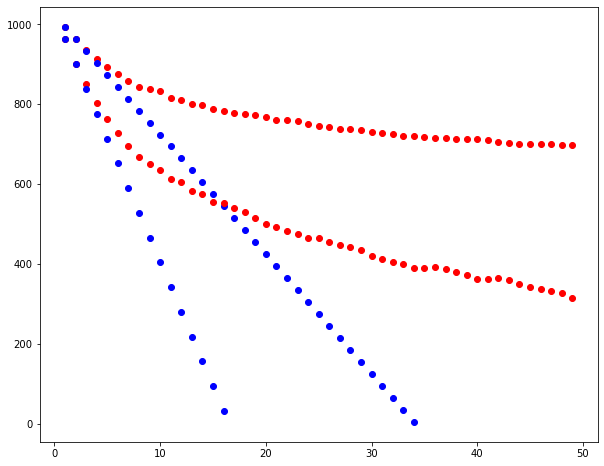

In [23]:
#plot only certain curves
#max_width vs niter of a few psf widths

psf_hwidth_range = [8, 16]


plt.figure(figsize=(10,8))

for phw0 in psf_hwidth_range:
    #Filters data for selected psf width in phw0
    filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]

    plt.scatter(filtered[:,0], filtered[:,2], c='red')

    filter =  maxwidths_vs_niter_and_psfhwidth_theory_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_theory_np[filter,:]
    plt.scatter(filtered[:,0], filtered[:,2], c='blue')


plt.show()


Try to fit exponential curve to the curve with psfwidth = 16

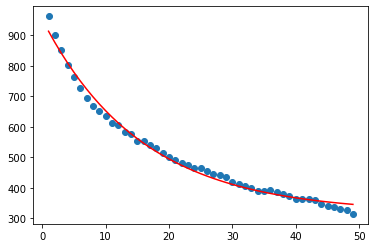

In [24]:
from scipy.optimize import curve_fit

#A = datacrop_width

def exp_func(x,a,b,c):
    return a*np.exp(b*x)+c

filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == 16
filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]

exp_fit_res = curve_fit(exp_func,filtered[:,0], filtered[:,2], p0=(1000,-1,100))

plt.scatter( filtered[:,0], filtered[:,2])
plt.plot(filtered[:,0], exp_func(filtered[:,0], *exp_fit_res[0]), c='red')

In [25]:
exp_fit_res[0] #Fitting parameters [a, b,c] of formula a*np.exp(b*x)+c

array([ 6.33510138e+02, -6.39761515e-02,  3.18679132e+02])

Interesting. The theoretical formula predicts that the decrease in max_valid_width should decrease linearly with niter. This is true at the first niter, but with increasing niter it curves up

## Compare with and without normalisation

In [27]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth_RL= []
maxwidths_vs_niter_and_psfhwidth_RL_with_norm= []
maxwidths_vs_niter_and_psfhwidth_theory = []

x_crop_0 = 512
datacrop_width = 1024

print(f"datacrop_width: {datacrop_width}")

for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0, x_crop_0+datacrop_width, niter0, phw0)
        maxwidths_vs_niter_and_psfhwidth_RL.append( (niter0,phw0,maxwidth) )

        #With normalisation
        maxwidth_norm = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0, x_crop_0+datacrop_width, niter0, phw0, do_edge_norm=True)
        maxwidths_vs_niter_and_psfhwidth_RL_with_norm.append( (niter0,phw0,maxwidth_norm) )

        maxwidth_theory = datacrop_width + niter0*(2-4*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_and_psfhwidth_theory.append((niter0,phw0, maxwidth_theory))

        print("niter0: ", niter0 , ", psf_half_width:", phw0 , ", maxwidth:", maxwidth, ", maxwidth_norm:", maxwidth_norm, " maxwidth_theory:", maxwidth_theory)


datacrop_width: 1024
niter0:  1 , psf_half_width: 8 , maxwidth: 994 , maxwidth_norm: 994  maxwidth_theory: 994
niter0:  1 , psf_half_width: 9 , maxwidth: 990 , maxwidth_norm: 990  maxwidth_theory: 990
niter0:  1 , psf_half_width: 10 , maxwidth: 986 , maxwidth_norm: 986  maxwidth_theory: 986
niter0:  1 , psf_half_width: 11 , maxwidth: 982 , maxwidth_norm: 982  maxwidth_theory: 982
niter0:  1 , psf_half_width: 12 , maxwidth: 978 , maxwidth_norm: 978  maxwidth_theory: 978
niter0:  1 , psf_half_width: 13 , maxwidth: 974 , maxwidth_norm: 974  maxwidth_theory: 974
niter0:  1 , psf_half_width: 14 , maxwidth: 970 , maxwidth_norm: 970  maxwidth_theory: 970
niter0:  1 , psf_half_width: 15 , maxwidth: 966 , maxwidth_norm: 966  maxwidth_theory: 966
niter0:  1 , psf_half_width: 16 , maxwidth: 962 , maxwidth_norm: 962  maxwidth_theory: 962
niter0:  1 , psf_half_width: 17 , maxwidth: 958 , maxwidth_norm: 958  maxwidth_theory: 958
niter0:  1 , psf_half_width: 18 , maxwidth: 954 , maxwidth_norm: 954  m

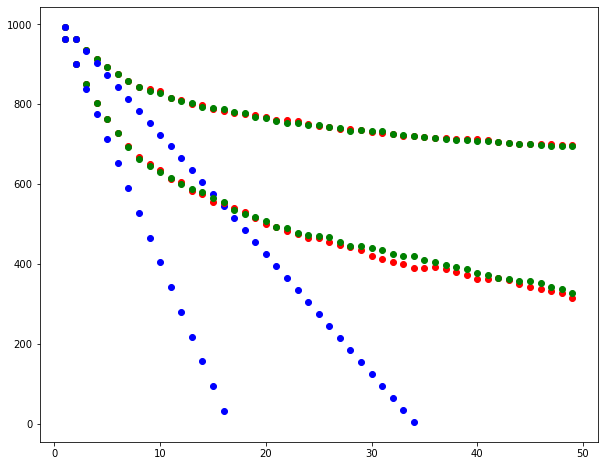

In [28]:
#plot only certain curves
#max_width vs niter of a few psf widths

maxwidths_vs_niter_and_psfhwidth_RL_np = np.array(maxwidths_vs_niter_and_psfhwidth_RL)
maxwidths_vs_niter_and_psfhwidth_RL_with_norm_np = np.array(maxwidths_vs_niter_and_psfhwidth_RL_with_norm)

maxwidths_vs_niter_and_psfhwidth_theory_np = np.array(maxwidths_vs_niter_and_psfhwidth_theory)

psf_hwidth_range = [8, 16]

plt.figure(figsize=(10,8))

for phw0 in psf_hwidth_range:
    #Filters data for selected psf width in phw0

    #red: without normalisation
    filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]
    plt.scatter(filtered[:,0], filtered[:,2], c='red')

    #green: with normalisation
    filter = maxwidths_vs_niter_and_psfhwidth_RL_with_norm_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_RL_with_norm_np[filter,:]
    plt.scatter(filtered[:,0], filtered[:,2], c='green')

    #theory
    filter =  maxwidths_vs_niter_and_psfhwidth_theory_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_theory_np[filter,:]
    plt.scatter(filtered[:,0], filtered[:,2], c='blue')


plt.show()


Difference between using and not using edge normalisation is rather neglegible.
In the future, in devising block iteration algorithms, this normalisation will not be prioritised.
It may improve results at the edge areas of the whole dataset.